In [1]:
#imports
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam
from functions.ep_optimizers import EpochEVE_allparams
from functions.mod_adam_eve import Adam_EVE_mb
from functions.eve_optimizer import GD_EVE, GD_EVE_mb, GD_EVE_allparams_mb, GD_EVE2_mb, GD_EVE2_allparams_mb, GD_EVE_mb_shuff, GD_EVE2_mb_shuff, EpochEVE, EpochEVE2, EpochEVE3

#generating approximately linear data from python func
from lin_reg_data import getLinRegDatasets

In [2]:
batch_size = 32

#time_lim = 15
num_epochs = 10

lr = 0.001
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Sun Sep 19 15:02:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   34C    P8    23W / 250W |  10046MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:0'

In [5]:
#init datasets and dataloaders

#setting data parameters
num_train = 5000
num_test = 100
y_dim = 100
x_dim = 100
m_var = 0.25
b_var = 0.25

#setting random number seed for data generation
np.random.seed(seed=0)

train_set, test_set, m, b = getLinRegDatasets(num_train, num_test,
                                            x_dim=x_dim, y_dim=y_dim,
                                            m_var=m_var, b_var=b_var)

train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_data_eval = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_data = DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = nn.Linear(x_dim, y_dim)
        self.param_updates = 0

    def forward(self, x):
        return self.lin(x)
    
loss_fn = nn.MSELoss()
model = Model()
model.to(device)

Model(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)

In [7]:
num_trials = 2


# this lets you choose the optimizers to use for each trial

# in this case, it is comparing Adam with and without EVE

optimizers = [Adam(model.parameters(), lr=lr, betas=betas),
              Adam(model.parameters(), lr=lr, betas=betas)]


ep_optimizers = [None, 
                 EpochEVE_allparams(model.parameters(), model, loss_fn, train_data_eval, 
                                    device, steps=[2**i for i in range(-2, 4)])]


trial_labels = ['Adam', 'Adam with EVE']

trial_colors = ['blue', 'orange', 'green', 'red', 'magenta']

In [8]:
#getting number of parameters in model
print("parameter name : num elements")
num_params = n_params(model, verbose=True)

param_states = []
train_losses = []
test_losses = []
train_times = []
test_times = []

parameter name : num elements
lin.weight size: 10000
lin.bias size: 100
Total num. parameters: 10100


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_minibatches
    return test_loss

In [10]:
# model.load_state_dict(vector_to_state_dict(np.array([0, 1]), model))
init_state = model.state_dict()
torch.save(init_state, 'init_state.pyt')

step_scalars = []

for trial in range(num_trials):
    
    
    trial_start_time = time.time()
    
    this_step_scalars = []
    this_train_times = []
    this_test_times = []
    this_train_loss = []
    this_test_loss = []
    this_param_states = []
    
    model.load_state_dict(torch.load('init_state.pyt'))
    print("Trial:", trial+1, '/', num_trials)
    
    #Choose optimizer
    optimizer = optimizers[trial]
    ep_optimizer = ep_optimizers[trial]
    
    #getting initial param state
    this_param_states.append(get_param_state(model))
    
    #Getting initial train and test loss
    this_train_loss.append(test(train_data, model, loss_fn))
    this_test_loss.append(test(test_data, model, loss_fn))
    
    this_train_times.append(0)
    this_test_times.append(0)
    
    #epoch index
    j = 0
    
    #use this line to run trials for the same amount of time
    #while time.time()-trial_start_time < time_lim:
    
    #use this line to run for the same number of epochs
    while j < num_epochs:
        print(' - Epoch: %i'%(j+1), 'time:', time.time()-trial_start_time)
        
        train(train_data, model, loss_fn, optimizer)
        
        this_train_loss.append(test(train_data, model, loss_fn))
        this_train_times.append(time.time()-trial_start_time)
        
        if ep_optimizer is not None:
            steps = ep_optimizer.step()
            this_step_scalars = this_step_scalars + steps
        
        this_param_states.append(get_param_state(model))
        this_test_loss.append(test(test_data, model, loss_fn))
        this_test_times.append(time.time()-trial_start_time)
        
        j += 1
        
    step_scalars.append(this_step_scalars)
    train_losses.append(np.array(this_train_loss))
    test_losses.append(np.array(this_test_loss))
    train_times.append(np.array(this_train_times))
    test_times.append(np.array(this_test_times))
    param_states.append(np.array(this_param_states))
        

Trial: 1 / 2
 - Epoch: 1 time: 0.15196728706359863
 - Epoch: 2 time: 0.6641032695770264
 - Epoch: 3 time: 1.1654975414276123
 - Epoch: 4 time: 1.7978909015655518
 - Epoch: 5 time: 2.366321563720703
 - Epoch: 6 time: 2.858207941055298
 - Epoch: 7 time: 3.3431456089019775
 - Epoch: 8 time: 3.8396706581115723
 - Epoch: 9 time: 4.336474418640137
 - Epoch: 10 time: 4.830209732055664
Trial: 2 / 2
 - Epoch: 1 time: 0.10929560661315918
 - Epoch: 2 time: 1.2301054000854492
 - Epoch: 3 time: 2.146986722946167
 - Epoch: 4 time: 3.065779447555542
 - Epoch: 5 time: 3.984992742538452
 - Epoch: 6 time: 4.920440912246704
 - Epoch: 7 time: 5.835582494735718
 - Epoch: 8 time: 6.750905990600586
 - Epoch: 9 time: 7.670876979827881
 - Epoch: 10 time: 8.5880446434021


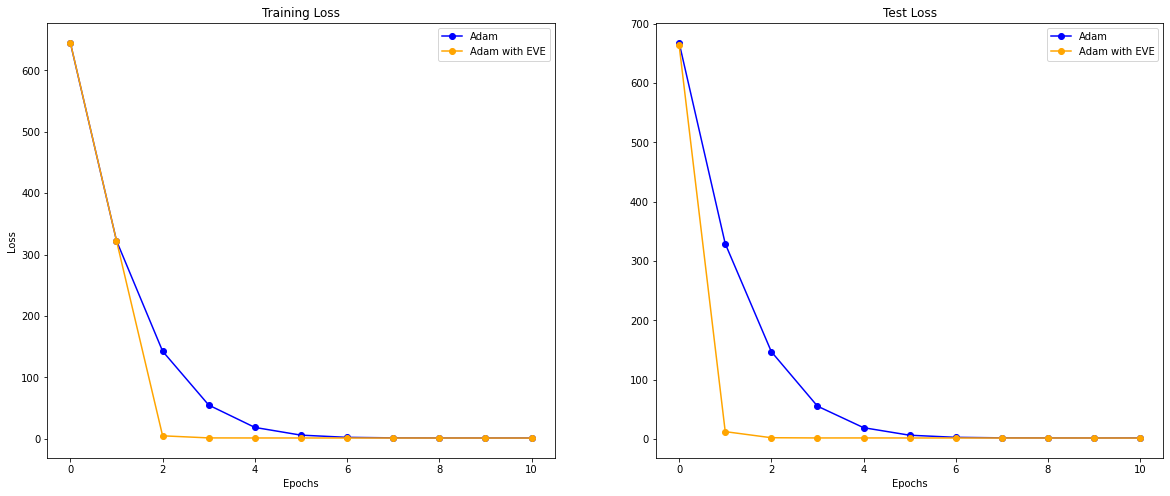

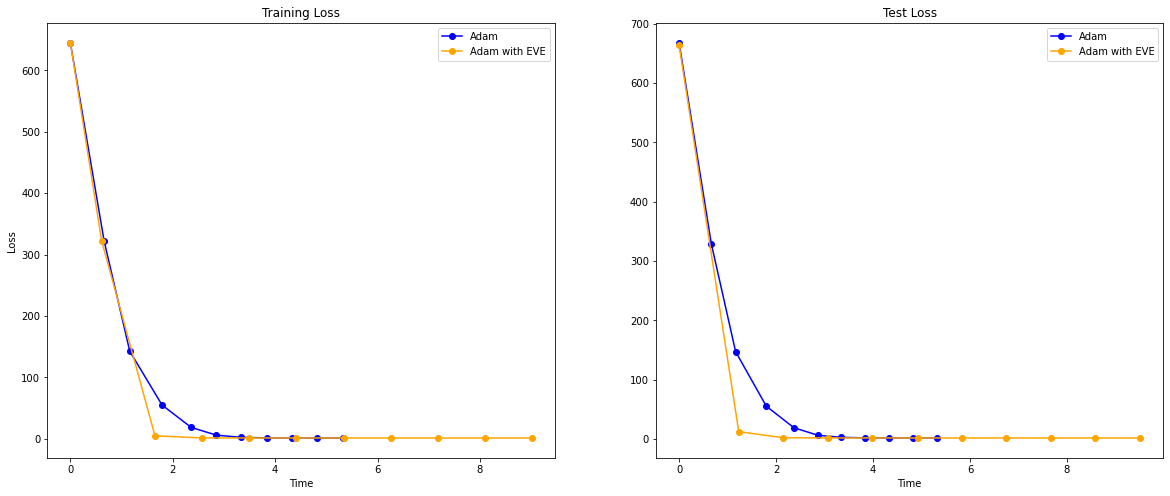

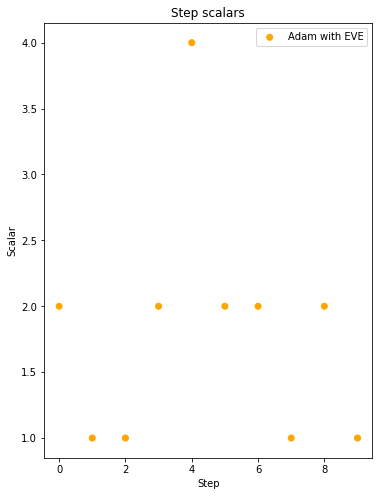

In [11]:
#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
for trial in range(num_trials):
    plt.plot(train_losses[trial], 'o-', label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
    
#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Epochs')
for trial in range(num_trials):
    plt.plot(test_losses[trial], 'o-', label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
for trial in range(num_trials):
    plt.plot(train_times[trial], train_losses[trial], 'o-', label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
    
#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Time')
for trial in range(num_trials):
    plt.plot(test_times[trial], test_losses[trial], 'o-', label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting step scalars over time

plt.figure(figsize=(20,8))
for trial in range(num_trials):  
    if len(step_scalars[trial]) > 0:
        #plt.figure(figsize=(12,8))
        plt.subplot(1, 3, trial+1)
        plt.title('Step scalars')
        plt.ylabel('Scalar')
        plt.xlabel('Step')
        plt.scatter([i for i in range(len(step_scalars[trial]))], step_scalars[trial], label=trial_labels[trial], c=[trial_colors[trial] for i in range(len(step_scalars[trial]))])
        plt.legend()

# plt.subplot(2, 2, 4)
# plt.title('Test Acc.')
# plt.xlabel('Num. epochs')
# for trial in range(num_trials):
#     plt.plot(test_acc[trial], 'o-', label=trial_opts[trial])
# plt.legend()

In [12]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [13]:
def angle_between(i, j, epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.arccos(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))

angle_grids = []
for trial in range(num_trials):
    this_grid_size = len(param_states[trial])-1
    this_angle_grid = np.zeros((this_grid_size, this_grid_size))
    for i in range(this_grid_size):
        for j in range(this_grid_size):
            this_angle_grid[i, j] = angle_between(i, j, epoch_steps = param_states[trial][1:]-param_states[trial][:-1])
    angle_grids.append(this_angle_grid)
    

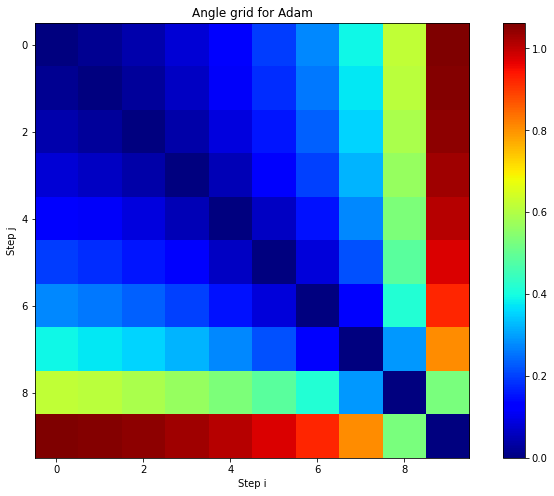

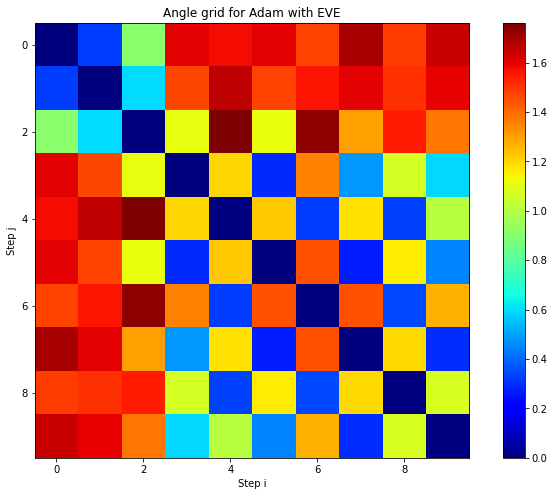

In [14]:
for trial in range(num_trials):
    plt.figure(figsize=(12,8))
    
    norm = colors.Normalize(vmin=np.amin(angle_grids[trial]), vmax=np.amax(angle_grids[trial]))   
    
    plt.imshow(angle_grids[trial], cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.title('Angle grid for '+trial_labels[trial])
    plt.xlabel('Step i')
    plt.ylabel('Step j')

time: 8.813369035720825
time: 8.647302865982056
time: 9.299388647079468
time: 8.585646867752075
time: 9.32375192642212
time: 8.840492248535156
time: 8.572411060333252
time: 8.464180946350098
time: 8.272990703582764
time: 9.042005777359009
time: 9.37282681465149
time: 9.68821930885315
time: 8.927045822143555
time: 8.811220645904541
time: 8.753872394561768
time: 9.107361555099487
time: 8.694611072540283
time: 8.66689395904541
time: 9.020281791687012
time: 9.140547513961792


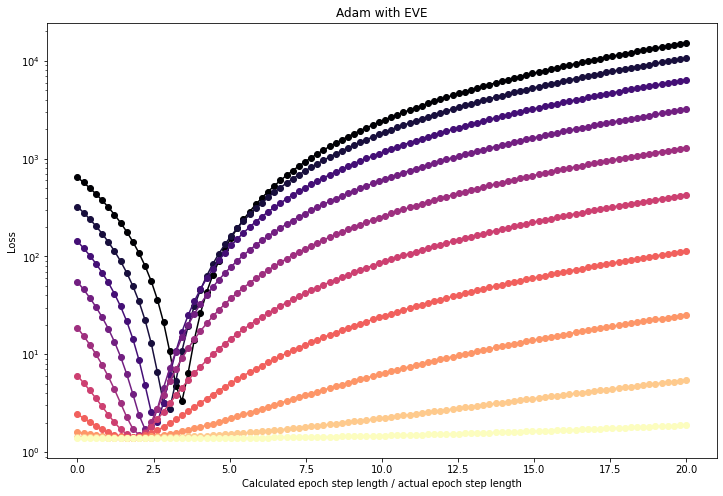

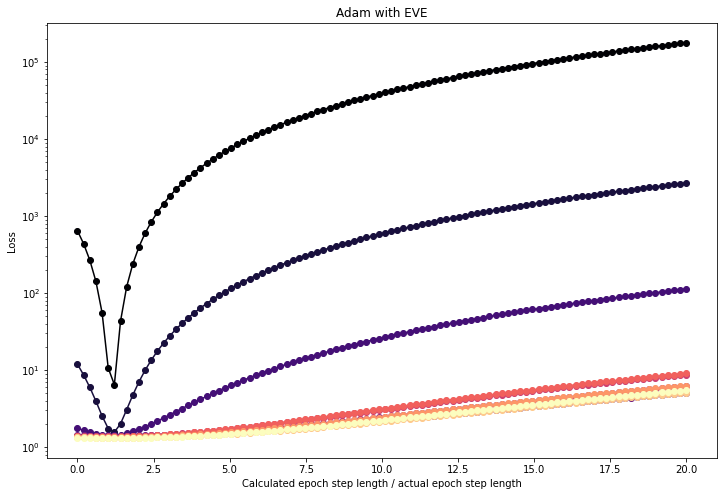

In [15]:
import time 
def scan_ahead(state_idx, num_steps=1, steps=[2**i for i in range(-2, 4)], epoch_states=param_states[0]):
    losses = []
    for step in steps:
        #print(step)
        #print(epoch_states[state_idx].shape, (epoch_states[state_idx+num_steps]-epoch_states[state_idx]).shape)
        param_state = epoch_states[state_idx] + step*(epoch_states[state_idx+num_steps]-epoch_states[state_idx])
        model.load_state_dict(vector_to_state_dict(param_state, model))
        this_loss = test(train_data_eval, model, loss_fn)
        #print(this_loss)
        losses.append(this_loss)
    return steps, losses

for j in range(num_trials):
    colors = cm.magma(np.linspace(0, 1, len(param_states[j])-1))

    plt.figure(figsize=(12,8))
    plt.title(trial_labels[trial])
    plt.xlabel('Calculated epoch step length / actual epoch step length')
    plt.ylabel('Loss')
    plt.yscale('log')

    for i in range(len(param_states[j])-1):

#         if (i+1) % 25 == 0:
#             plt.figure(figsize=(12,8))
#             plt.xlabel('Calculated epoch step length / actual epoch step length')
#             plt.ylabel('Loss')
#             plt.yscale('log')

        init_time = time.time()
        steps, losses = scan_ahead(i, steps=np.linspace(0,20,100), epoch_states=param_states[j])
        #print('time:', time.time()-init_time)
        plt.plot(steps, losses, 'o-', color=colors[i])